In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!mkdir hateful_memes
!unzip gdrive/MyDrive/data.zip -d /content/hateful_memes/

In [ ]:
!pip install transformers torch torchvision tqdm scikit-learn matplotlib seaborn wandb pillow opencv-python

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import clip
from tqdm.notebook import tqdm
import cv2
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import random
from google.colab import drive

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


DATA_ROOT = "/content/hateful_memes"

Using device: cuda


In [ ]:
# Define constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5  # Reduced for Colab
LEARNING_RATE = 2e-5

# Define hate subtypes
HATE_SUBTYPES = ['racial', 'gender', 'religion', 'political', 'other']

# Define severity levels
SEVERITY_LEVELS = ['low', 'medium', 'high']

# Image transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                       (0.26862954, 0.26130258, 0.27577711))
])

In [ ]:
# Define dataset classes
class HatefulMemesDataset(Dataset):
    def __init__(self, data_path, split="train", transform=None):
        """
        Args:
            data_path: Path to the Hateful Memes dataset
            split: 'train', 'dev', or 'test'
            transform: Image transformations
        """
        self.data_path = data_path
        self.split = split
        self.transform = transform

        # Load annotations
        with open(os.path.join(data_path, f"{split}.jsonl"), 'r') as f:
            self.data = [json.loads(line) for line in f]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load image
        img_path = os.path.join(self.data_path, item['img'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Get text
        text = item['text']

        # Get label (0 for not hateful, 1 for hateful)
        label = torch.tensor(item['label']).float()

        # Get ID for reference
        id = item['id']

        return {
            'image': image,
            'text': text,
            'label': label,
            'id': id,
            'img_path': img_path
        }

In [ ]:
class MultilabelHatefulMemesDataset(HatefulMemesDataset):
    def __init__(self, data_path, split="train", transform=None,
                 extended_labels_path=None):
        super().__init__(data_path, split, transform)

        # If extended labels are provided, load them
        self.has_extended_labels = False
        if extended_labels_path and os.path.exists(extended_labels_path):
            with open(extended_labels_path, 'r') as f:
                self.extended_labels = json.load(f)
            self.has_extended_labels = True

    def __getitem__(self, idx):
        item = super().__getitem__(idx)

        # Add extended labels if available
        if self.has_extended_labels and str(item['id']) in self.extended_labels:
            ext_label = self.extended_labels[str(item['id'])]
            item['severity'] = torch.tensor(SEVERITY_LEVELS.index(ext_label['severity'])) if 'severity' in ext_label else torch.tensor(-1)

            # One-hot encode subtypes
            subtypes = torch.zeros(len(HATE_SUBTYPES))
            if 'subtypes' in ext_label:
                for subtype in ext_label['subtypes']:
                    if subtype in HATE_SUBTYPES:
                        subtypes[HATE_SUBTYPES.index(subtype)] = 1
            item['subtypes'] = subtypes
        else:
            # Default values if extended labels not available
            item['severity'] = torch.tensor(-1)
            item['subtypes'] = torch.zeros(len(HATE_SUBTYPES))

        return item

In [ ]:
    def safe_tokenize(texts, context_length=77):
        """
        Safely tokenize text for CLIP by truncating if necessary

        Args:
            texts: List of texts to tokenize
            context_length: Maximum context length (default: 77 for CLIP)

        Returns:
            Tokenized texts as a tensor
        """
        if isinstance(texts, str):
            texts = [texts]

        try:
            return clip.tokenize(texts, context_length=context_length)
        except RuntimeError:
            import re
            from clip.simple_tokenizer import SimpleTokenizer

            tokenizer = SimpleTokenizer()
            sot_token = tokenizer.encoder["<|startoftext|>"]
            eot_token = tokenizer.encoder["<|endoftext|>"]

            max_tokens = context_length - 2

            result = torch.zeros(len(texts), context_length, dtype=torch.long)

            for i, text in enumerate(texts):
                tokens = tokenizer.encode(text)

                # Truncate if needed
                if len(tokens) > max_tokens:
                    words = re.findall(r'\b\w+\b', text)
                    truncated_text = ""
                    token_count = 0

                    for word in words:
                        word_tokens = tokenizer.encode(" " + word)
                        if token_count + len(word_tokens) <= max_tokens:
                            truncated_text += " " + word
                            token_count += len(word_tokens)
                        else:
                            break

                    if not truncated_text:
                        tokens = tokens[:max_tokens]
                    else:
                        tokens = tokenizer.encode(truncated_text)

                tokens = [sot_token] + tokens + [eot_token]

                tokens = tokens[:context_length]

                result[i, :len(tokens)] = torch.tensor(tokens)

            return result

In [ ]:
class HatefulMemesDetector(nn.Module):
    def __init__(self, clip_model, clip_preprocess):
        super(HatefulMemesDetector, self).__init__()

        self.clip_model = clip_model

        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # Get CLIP embedding dimensions
        with torch.no_grad():
            dummy_image = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(device)
            dummy_text = clip.tokenize(["dummy text"]).to(device)
            image_features = self.clip_model.encode_image(dummy_image)
            text_features = self.clip_model.encode_text(dummy_text)

            self.image_dim = image_features.shape[1]
            self.text_dim = text_features.shape[1]
            self.fusion_dim = self.image_dim + self.text_dim

        self.feature_interaction = nn.Linear(self.fusion_dim, self.fusion_dim)

        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

        # Severity level classifier (low, medium, high)
        self.severity_classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, len(SEVERITY_LEVELS))
        )

        # Subtype classifier (multilabel)
        self.subtype_classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, len(HATE_SUBTYPES))
        )

        # Attention layers for explanation
        self.image_attention = nn.Linear(self.image_dim, 1)
        self.text_attention = nn.Linear(self.text_dim, 1)


    def forward(self, images, text_tokens=None, texts=None):
        """
        Forward pass through the model

        Args:
            images: Batch of images
            text_tokens: Preprocessed text tokens (optional)
            texts: Raw text strings (optional)

        Note: Either text_tokens or texts must be provided
        """
        if text_tokens is None and texts is None:
            raise ValueError("Either text_tokens or texts must be provided")

        if text_tokens is None and texts is not None:
            text_tokens = safe_tokenize(texts).to(images.device)

        # Extract image features
        image_features = self.clip_model.encode_image(images)

        # Extract text features
        text_features = self.clip_model.encode_text(text_tokens)

        # convert features to float32
        image_features = image_features.float()
        text_features = text_features.float()

        # normalize
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # concatenate
        combined_features = torch.cat([image_features, text_features], dim=1)

        # feature interaction
        enhanced_features = self.feature_interaction(combined_features)
        enhanced_features = F.relu(enhanced_features)

        hate_logits = self.classifier(enhanced_features).squeeze(1)

        # Severity classification
        severity_logits = self.severity_classifier(enhanced_features)

        # Subtype classification
        subtype_logits = self.subtype_classifier(enhanced_features)

        # Calculate attention weights for explanation
        image_attention = self.image_attention(image_features)
        text_attention = self.text_attention(text_features)

        return {
            'hate_logits': hate_logits,
            'severity_logits': severity_logits,
            'subtype_logits': subtype_logits,
            'image_attention': image_attention,
            'text_attention': text_attention,
            'image_features': image_features,
            'text_features': text_features
        }

    def predict(self, images, text_tokens=None, texts=None):
        """Complete prediction with thresholding"""
        outputs = self.forward(images, text_tokens, texts)

        # Binary hate prediction
        hate_probs = torch.sigmoid(outputs['hate_logits'])
        hate_preds = (hate_probs > 0.5).float()

        # Severity prediction
        severity_probs = F.softmax(outputs['severity_logits'], dim=1)
        severity_preds = torch.argmax(severity_probs, dim=1)

        # Subtype predictions (multilabel)
        subtype_probs = torch.sigmoid(outputs['subtype_logits'])
        subtype_preds = (subtype_probs > 0.5).float()

        return {
            'hate_probs': hate_probs,
            'hate_preds': hate_preds,
            'severity_probs': severity_probs,
            'severity_preds': severity_preds,
            'subtype_probs': subtype_probs,
            'subtype_preds': subtype_preds,
            'image_attention': outputs['image_attention'],
            'text_attention': outputs['text_attention']
        }

In [ ]:
def create_dummy_extended_labels(data_path):
    """
    Creates a dummy extended labels file for demonstration purposes
    In a real scenario, you would have annotated data with severity and subtypes
    """
    # Load datasets
    train_path = os.path.join(data_path, "train.jsonl")
    dev_path = os.path.join(data_path, "dev.jsonl")

    extended_labels = {}

    # Process train data
    with open(train_path, 'r') as f:
        for line in f:
            item = json.loads(line)
            if item['label'] == 1:
                severity = random.choice(SEVERITY_LEVELS)

                num_subtypes = random.randint(1, 3)
                subtypes = random.sample(HATE_SUBTYPES, num_subtypes)

                extended_labels[str(item['id'])] = {
                    'severity': severity,
                    'subtypes': subtypes
                }

    with open(dev_path, 'r') as f:
        for line in f:
            item = json.loads(line)
            if item['label'] == 1:
                # Randomly assign severity and subtypes
                severity = random.choice(SEVERITY_LEVELS)

                # Randomly select 1-2 subtypes
                num_subtypes = random.randint(1, 3)
                subtypes = random.sample(HATE_SUBTYPES, num_subtypes)

                extended_labels[str(item['id'])] = {
                    'severity': severity,
                    'subtypes': subtypes
                }

    # Save extended labels
    with open(os.path.join(data_path, "extended_labels.json"), 'w') as f:
        json.dump(extended_labels, f)

    print(f"Created dummy extended labels for {len(extended_labels)} hateful memes")

if not os.path.exists(os.path.join(DATA_ROOT, "extended_labels.json")):
    print("Extended labels file not found. Creating dummy data...")
    create_dummy_extended_labels(DATA_ROOT)

In [ ]:
# Create datasets and dataloaders
print("Loading datasets...")
train_dataset = MultilabelHatefulMemesDataset(
    DATA_ROOT, split="train", transform=transform,
    extended_labels_path=os.path.join(DATA_ROOT, "extended_labels.json")
)

val_dataset = MultilabelHatefulMemesDataset(
    DATA_ROOT, split="dev", transform=transform,
    extended_labels_path=os.path.join(DATA_ROOT, "extended_labels.json")
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

print("Loading CLIP model...")
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

Loading datasets...
Train dataset size: 8500
Validation dataset size: 500
Loading CLIP model...


In [ ]:
print("Creating hateful memes detector model...")
model = HatefulMemesDetector(clip_model, clip_preprocess).to(device)

# loss functions
criterion_dict = {
    'hate': nn.BCEWithLogitsLoss(),
    'severity': nn.CrossEntropyLoss(),
    'subtype': nn.BCEWithLogitsLoss()
}

# optimizer and scheduler
optimizer = optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=LEARNING_RATE
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2
)

Creating hateful memes detector model...


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion_dict,
                epochs=5, device=device, scheduler=None,
                early_stopping_patience=15):

    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_model_state = None

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_f1': [],
        'val_f1': [],
        'val_auc': []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Train
        model.train()
        train_loss = 0.0
        train_hate_preds = []
        train_hate_labels = []

        for batch in tqdm(train_loader):
            # Move to device
            images = batch['image'].to(device)
            texts = batch['text']  # Keep as strings
            hate_labels = batch['label'].to(device)
            severity_labels = batch['severity'].to(device)
            subtype_labels = batch['subtypes'].to(device)

            optimizer.zero_grad()

            outputs = model(images, texts=texts)

            hate_loss = criterion_dict['hate'](outputs['hate_logits'], hate_labels)

            # Only calculate severity loss for samples with valid severity labels
            severity_loss = 0.0
            valid_severity_mask = severity_labels >= 0
            if valid_severity_mask.sum() > 0:
                severity_loss = criterion_dict['severity'](
                    outputs['severity_logits'][valid_severity_mask],
                    severity_labels[valid_severity_mask]
                )

            # Calculate subtype loss only for hateful samples
            subtype_loss = 0.0
            hateful_mask = hate_labels == 1
            if hateful_mask.sum() > 0:
                subtype_loss = criterion_dict['subtype'](
                    outputs['subtype_logits'][hateful_mask],
                    subtype_labels[hateful_mask]
                )

            # Combined loss
            loss = hate_loss + 0.5 * severity_loss + 0.5 * subtype_loss

            loss.backward()
            optimizer.step()

            # Update metrics
            train_loss += loss.item()
            train_hate_preds.extend(torch.sigmoid(outputs['hate_logits']).detach().cpu().numpy() > 0.5)
            train_hate_labels.extend(hate_labels.detach().cpu().numpy())

        # Calculate training metrics
        train_accuracy = accuracy_score(train_hate_labels, train_hate_preds)
        train_f1 = f1_score(train_hate_labels, train_hate_preds)
        train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_hate_preds = []
        val_hate_probs = []
        val_hate_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader):
                # Move to device
                images = batch['image'].to(device)
                texts = batch['text']  # Keep as strings
                hate_labels = batch['label'].to(device)
                severity_labels = batch['severity'].to(device)
                subtype_labels = batch['subtypes'].to(device)

                outputs = model(images, texts=texts)

                hate_loss = criterion_dict['hate'](outputs['hate_logits'], hate_labels)

                severity_loss = 0.0
                valid_severity_mask = severity_labels >= 0
                if valid_severity_mask.sum() > 0:
                    severity_loss = criterion_dict['severity'](
                        outputs['severity_logits'][valid_severity_mask],
                        severity_labels[valid_severity_mask]
                    )

                subtype_loss = 0.0
                hateful_mask = hate_labels == 1
                if hateful_mask.sum() > 0:
                    subtype_loss = criterion_dict['subtype'](
                        outputs['subtype_logits'][hateful_mask],
                        subtype_labels[hateful_mask]
                    )

                # Combined loss
                loss = hate_loss + 0.5 * severity_loss + 0.5 * subtype_loss

                val_loss += loss.item()

                hate_probs = torch.sigmoid(outputs['hate_logits']).detach().cpu().numpy()
                hate_preds = (hate_probs > 0.5).astype(int)

                val_hate_probs.extend(hate_probs)
                val_hate_preds.extend(hate_preds)
                val_hate_labels.extend(hate_labels.detach().cpu().numpy())

        # Calculate metrics
        val_accuracy = accuracy_score(val_hate_labels, val_hate_preds)
        val_f1 = f1_score(val_hate_labels, val_hate_preds)
        val_auc = roc_auc_score(val_hate_labels, val_hate_probs)
        val_loss = val_loss / len(val_loader)

        if scheduler:
            scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history

Starting training...

Epoch 1/5


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 1.5684, Accuracy: 0.6412, F1: 0.0000
Val Loss: 1.5978, Accuracy: 0.5000, F1: 0.0000, AUC: 0.5713

Epoch 2/5


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 1.5329, Accuracy: 0.6412, F1: 0.0000
Val Loss: 1.6149, Accuracy: 0.5000, F1: 0.0000, AUC: 0.6296

Epoch 3/5


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 1.5079, Accuracy: 0.6413, F1: 0.0007
Val Loss: 1.6108, Accuracy: 0.5000, F1: 0.0000, AUC: 0.6448

Epoch 4/5


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 1.4674, Accuracy: 0.6829, F1: 0.2939
Val Loss: 1.5931, Accuracy: 0.5500, F1: 0.3077, AUC: 0.6520

Epoch 5/5


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 1.4340, Accuracy: 0.7229, F1: 0.5238
Val Loss: 1.6288, Accuracy: 0.5560, F1: 0.3353, AUC: 0.6561


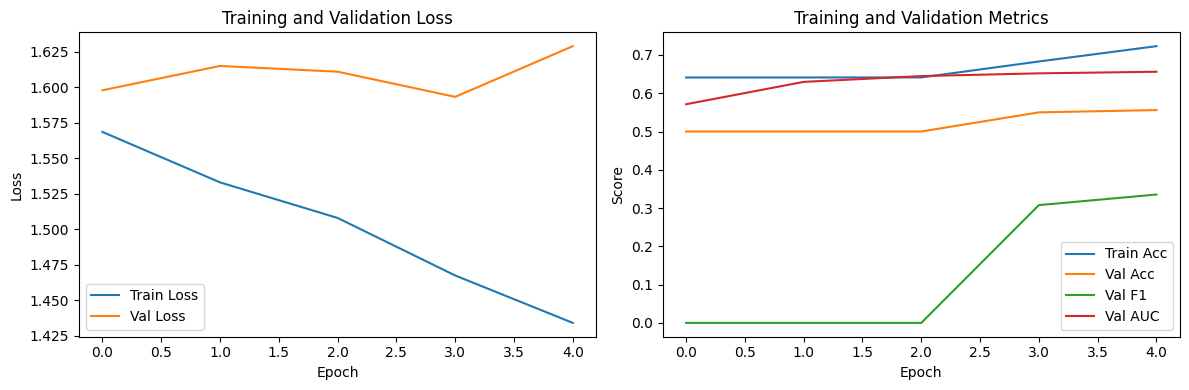

In [ ]:
# Train
print("Starting training...")
model, history = train_model(
    model, train_loader, val_loader, optimizer, criterion_dict,
    epochs=EPOCHS, device=device, scheduler=scheduler
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.plot(history['val_f1'], label='Val F1')
plt.plot(history['val_auc'], label='Val AUC')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def count_classes(data_loader):
    labels = []
    for batch in data_loader:
        labels.extend(batch['label'].cpu().numpy())

    class_counts = np.bincount(np.array(labels).astype(int))
    print(f"Class 0 (Not Hateful): {class_counts[0]} ({class_counts[0]/len(labels)*100:.2f}%)")
    print(f"Class 1 (Hateful): {class_counts[1]} ({class_counts[1]/len(labels)*100:.2f}%)")

    return class_counts

print("Analyzing training data...")
train_class_counts = count_classes(train_loader)
val_class_counts = count_classes(val_loader)

# Calculate class weights for loss function
total_samples = sum(train_class_counts)
class_weights = torch.tensor([
    total_samples / (2 * train_class_counts[0]),
    total_samples / (2 * train_class_counts[1])
], dtype=torch.float32).to(device)

print(f"Using class weights: {class_weights}")

weighted_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights[1] / class_weights[0]]).to(device))

criterion_dict = {
    'hate': weighted_criterion,
    'severity': nn.CrossEntropyLoss(),
    'subtype': nn.BCEWithLogitsLoss()
}

for param_group in optimizer.param_groups:
    param_group['lr'] = 3e-4  # Increase from 2e-5 to 3e-4

print(f"Increased learning rate to: {optimizer.param_groups[0]['lr']}")

torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=3e-4,
    weight_decay=0.01  # Add weight decay
)


Analyzing training data...
Class 0 (Not Hateful): 5450 (64.12%)
Class 1 (Hateful): 3050 (35.88%)
Class 0 (Not Hateful): 250 (50.00%)
Class 1 (Hateful): 250 (50.00%)
Using class weights: tensor([0.7798, 1.3934], device='cuda:0')
Increased learning rate to: 0.0003
Applied quick fixes to improve model training!
Restart training with these modifications for better performance.


Starting training...

Epoch 1/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 1.1435, Accuracy: 0.9033, F1: 0.8723
Val Loss: 2.2394, Accuracy: 0.6520, F1: 0.6217, AUC: 0.7236

Epoch 2/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.9911, Accuracy: 0.9394, F1: 0.9186
Val Loss: 3.0904, Accuracy: 0.6020, F1: 0.4518, AUC: 0.7288

Epoch 3/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.8600, Accuracy: 0.9711, F1: 0.9603
Val Loss: 2.8909, Accuracy: 0.6580, F1: 0.6157, AUC: 0.7203

Epoch 4/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.7699, Accuracy: 0.9811, F1: 0.9739
Val Loss: 2.8294, Accuracy: 0.6700, F1: 0.6512, AUC: 0.7235

Epoch 5/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.6898, Accuracy: 0.9831, F1: 0.9766
Val Loss: 3.1522, Accuracy: 0.6540, F1: 0.6077, AUC: 0.7311

Epoch 6/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.6003, Accuracy: 0.9878, F1: 0.9831
Val Loss: 3.2582, Accuracy: 0.6660, F1: 0.6281, AUC: 0.7390

Epoch 7/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.5098, Accuracy: 0.9904, F1: 0.9866
Val Loss: 3.7067, Accuracy: 0.6640, F1: 0.6129, AUC: 0.7354

Epoch 8/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.4794, Accuracy: 0.9842, F1: 0.9782
Val Loss: 4.3336, Accuracy: 0.6300, F1: 0.5119, AUC: 0.7403

Epoch 9/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.4164, Accuracy: 0.9919, F1: 0.9887
Val Loss: 4.9979, Accuracy: 0.6280, F1: 0.4862, AUC: 0.7360

Epoch 10/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3913, Accuracy: 0.9913, F1: 0.9879
Val Loss: 4.7974, Accuracy: 0.6400, F1: 0.5361, AUC: 0.7288

Epoch 11/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3854, Accuracy: 0.9879, F1: 0.9832
Val Loss: 5.0130, Accuracy: 0.6180, F1: 0.5065, AUC: 0.7350

Epoch 12/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3683, Accuracy: 0.9901, F1: 0.9863
Val Loss: 4.5863, Accuracy: 0.6460, F1: 0.5931, AUC: 0.7316

Epoch 13/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3310, Accuracy: 0.9940, F1: 0.9917
Val Loss: 4.6417, Accuracy: 0.6540, F1: 0.6023, AUC: 0.7317

Epoch 14/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3272, Accuracy: 0.9908, F1: 0.9873
Val Loss: 5.2908, Accuracy: 0.6460, F1: 0.5473, AUC: 0.7336

Epoch 15/15


  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3192, Accuracy: 0.9892, F1: 0.9850
Val Loss: 4.7322, Accuracy: 0.6580, F1: 0.6069, AUC: 0.7384


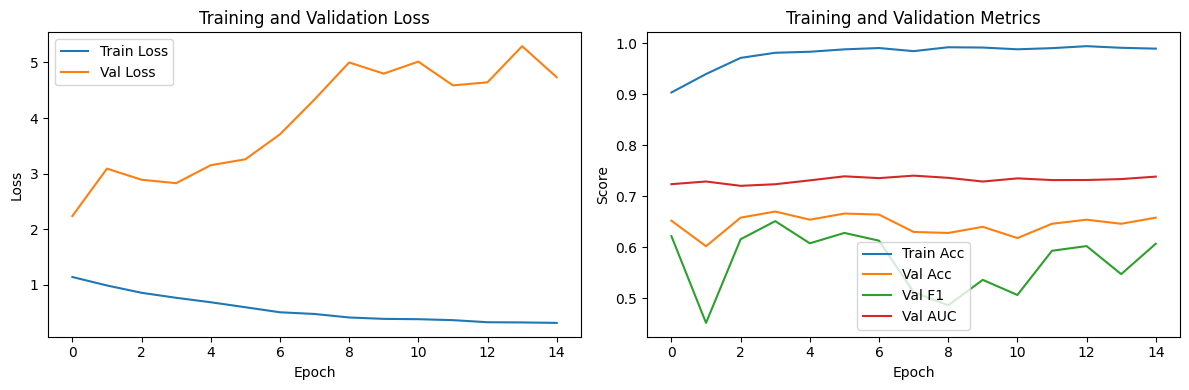

In [ ]:
# Train the model
print("Starting training...")
model, history = train_model(
    model, train_loader, val_loader, optimizer, criterion_dict,
    epochs=15, device=device, scheduler=scheduler
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.plot(history['val_f1'], label='Val F1')
plt.plot(history['val_auc'], label='Val AUC')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

Creating augmented datasets...
Creating regularized model...
Analyzing class distribution...
Class ratio (non-hateful:hateful): 1.79
Starting regularized training...
Starting training for 15 epochs with early stopping patience 5

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.3487, Accuracy: 0.6409, F1: 0.2809
Val Loss: 1.4545, Accuracy: 0.5420, F1: 0.3082, AUC: 0.6577
New best model saved with val F1: 0.3082

Epoch 2/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.2700, Accuracy: 0.6922, F1: 0.4646
Val Loss: 1.5335, Accuracy: 0.5620, F1: 0.3761, AUC: 0.6628
New best model saved with val F1: 0.3761

Epoch 3/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c2ab1bbdbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^Exception ignored in: 
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c2ab1bbdbc0>
    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
     File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive(): 
^^^^  ^  ^  ^ ^^^^^^^^^^^^^^^^^^

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.2454, Accuracy: 0.7094, F1: 0.5263
Val Loss: 1.5006, Accuracy: 0.5720, F1: 0.4309, AUC: 0.6644
New best model saved with val F1: 0.4309

Epoch 4/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.2151, Accuracy: 0.7231, F1: 0.5547
Val Loss: 1.5395, Accuracy: 0.5620, F1: 0.4191, AUC: 0.6640
No improvement for 1 epochs

Epoch 5/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.2042, Accuracy: 0.7241, F1: 0.5644
Val Loss: 1.5139, Accuracy: 0.5660, F1: 0.4274, AUC: 0.6673
No improvement for 2 epochs

Epoch 6/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1880, Accuracy: 0.7378, F1: 0.5894
Val Loss: 1.5181, Accuracy: 0.5740, F1: 0.4496, AUC: 0.6701
New best model saved with val F1: 0.4496

Epoch 7/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1763, Accuracy: 0.7409, F1: 0.5988
Val Loss: 1.5335, Accuracy: 0.5740, F1: 0.4468, AUC: 0.6755
No improvement for 1 epochs

Epoch 8/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1754, Accuracy: 0.7431, F1: 0.6022
Val Loss: 1.5238, Accuracy: 0.5700, F1: 0.4444, AUC: 0.6765
No improvement for 2 epochs

Epoch 9/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1778, Accuracy: 0.7406, F1: 0.6022
Val Loss: 1.5152, Accuracy: 0.5820, F1: 0.4627, AUC: 0.6796
New best model saved with val F1: 0.4627

Epoch 10/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1741, Accuracy: 0.7427, F1: 0.6023
Val Loss: 1.5209, Accuracy: 0.5880, F1: 0.4607, AUC: 0.6802
No improvement for 1 epochs

Epoch 11/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c2ab1bbdbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c2ab1bbdbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1641, Accuracy: 0.7471, F1: 0.6051
Val Loss: 1.5020, Accuracy: 0.5940, F1: 0.4912, AUC: 0.6806
New best model saved with val F1: 0.4912

Epoch 12/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1577, Accuracy: 0.7482, F1: 0.6163
Val Loss: 1.5316, Accuracy: 0.5920, F1: 0.4660, AUC: 0.6812
No improvement for 1 epochs

Epoch 13/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c2ab1bbdbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c2ab1bbdbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1550, Accuracy: 0.7534, F1: 0.6168
Val Loss: 1.5215, Accuracy: 0.5960, F1: 0.4873, AUC: 0.6821
No improvement for 2 epochs

Epoch 14/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1582, Accuracy: 0.7482, F1: 0.6174
Val Loss: 1.5358, Accuracy: 0.5940, F1: 0.4727, AUC: 0.6827
No improvement for 3 epochs

Epoch 15/15


Training:   0%|          | 0/532 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1524, Accuracy: 0.7527, F1: 0.6157
Val Loss: 1.5280, Accuracy: 0.5960, F1: 0.4847, AUC: 0.6829
No improvement for 4 epochs
Loaded best model with validation F1: 0.4912


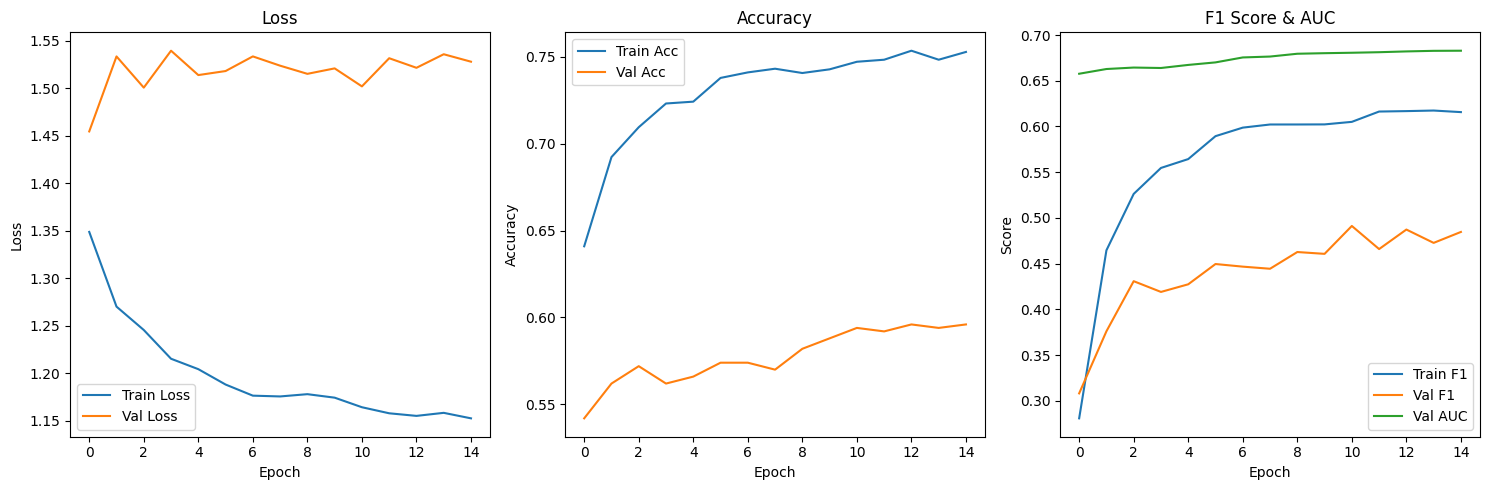

Saving regularized model...
Training complete!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import random
from tqdm.auto import tqdm
from torchvision import transforms

class RegularizedHatefulMemesDetector(nn.Module):
    def __init__(self, clip_model, clip_preprocess):
        super(RegularizedHatefulMemesDetector, self).__init__()

        self.clip_model = clip_model

        for param in self.clip_model.parameters():
            param.requires_grad = False

        with torch.no_grad():
            dummy_image = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(device)
            dummy_text = clip.tokenize(["dummy text"]).to(device)
            image_features = self.clip_model.encode_image(dummy_image)
            text_features = self.clip_model.encode_text(dummy_text)

            self.image_dim = image_features.shape[1]
            self.text_dim = text_features.shape[1]
            self.fusion_dim = self.image_dim + self.text_dim

        self.feature_fusion = nn.Sequential(
            nn.Linear(self.fusion_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

        self.severity_classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(128, len(SEVERITY_LEVELS))
        )

        self.subtype_classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(128, len(HATE_SUBTYPES))
        )

        self.image_attention = nn.Linear(self.image_dim, 1)
        self.text_attention = nn.Linear(self.text_dim, 1)

    def forward(self, images, text_tokens=None, texts=None):
        if text_tokens is None and texts is None:
            raise ValueError("Either text_tokens or texts must be provided")

        if text_tokens is None and texts is not None:
            text_tokens = safe_tokenize(texts).to(images.device)

        # Extract image features
        image_features = self.clip_model.encode_image(images)

        # Extract text features
        text_features = self.clip_model.encode_text(text_tokens)

        # Convert features to float32
        image_features = image_features.float()
        text_features = text_features.float()

        # dropout layers
        if self.training:
            image_features = F.dropout(image_features, p=0.2)
            text_features = F.dropout(text_features, p=0.2)

        # normalize
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # Concatenate
        combined_features = torch.cat([image_features, text_features], dim=1)

        # fusion
        fused_features = self.feature_fusion(combined_features)

        # Classification outputs
        hate_logits = self.classifier(fused_features).squeeze(1)
        severity_logits = self.severity_classifier(fused_features)
        subtype_logits = self.subtype_classifier(fused_features)

        # Attention for explanation
        image_attention = self.image_attention(image_features)
        text_attention = self.text_attention(text_features)

        return {
            'hate_logits': hate_logits,
            'severity_logits': severity_logits,
            'subtype_logits': subtype_logits,
            'image_attention': image_attention,
            'text_attention': text_attention,
            'image_features': image_features,
            'text_features': text_features
        }

    def predict(self, images, text_tokens=None, texts=None):
        self.eval()
        outputs = self.forward(images, text_tokens, texts)

        # Binary hate prediction
        hate_probs = torch.sigmoid(outputs['hate_logits'])
        hate_preds = (hate_probs > 0.5).float()

        # Severity prediction
        severity_probs = F.softmax(outputs['severity_logits'], dim=1)
        severity_preds = torch.argmax(severity_probs, dim=1)

        # Subtype predictions (multilabel)
        subtype_probs = torch.sigmoid(outputs['subtype_logits'])
        subtype_preds = (subtype_probs > 0.5).float()

        return {
            'hate_probs': hate_probs,
            'hate_preds': hate_preds,
            'severity_probs': severity_probs,
            'severity_preds': severity_preds,
            'subtype_probs': subtype_probs,
            'subtype_preds': subtype_preds,
            'image_attention': outputs['image_attention'],
            'text_attention': outputs['text_attention']
        }

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
])

# Text augmentation
def augment_text(text, p=0.3):
    if random.random() > p:
        return text

    words = text.split()
    if len(words) <= 2:
        return text

    aug_type = random.choice(['swap', 'drop'])

    if aug_type == 'swap' and len(words) >= 3:
        idx = random.randint(0, len(words) - 2)
        words[idx], words[idx+1] = words[idx+1], words[idx]
    elif aug_type == 'drop' and len(words) >= 3:
        idx = random.randint(1, len(words) - 2)
        words.pop(idx)

    return ' '.join(words)

# Dataset with augmentation
class AugmentedDataset(MultilabelHatefulMemesDataset):
    def __init__(self, data_path, split="train", transform=None,
                 extended_labels_path=None, apply_augmentation=True):
        super().__init__(data_path, split, transform, extended_labels_path)
        self.apply_augmentation = apply_augmentation and split == "train"

    def __getitem__(self, idx):
        item = super().__getitem__(idx)

        if self.apply_augmentation:
            item['text'] = augment_text(item['text'])

        return item

# Label smoothing loss
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1, weight=None):
        super().__init__()
        self.smoothing = smoothing
        self.weight = weight

    def forward(self, pred, target):
        smoothed_target = target * (1 - self.smoothing) + 0.5 * self.smoothing

        return F.binary_cross_entropy_with_logits(pred, smoothed_target, weight=self.weight)

def train_with_regularization(model, train_loader, val_loader, optimizer, criterion_dict,
                             epochs=15, device=device, scheduler=None):
    best_val_f1 = 0.0
    early_stopping_counter = 0
    best_model_state = None
    patience = 5

    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_accuracy': [], 'val_accuracy': [],
        'train_f1': [], 'val_f1': [], 'val_auc': []
    }

    print(f"Starting training for {epochs} epochs with early stopping patience {patience}")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for batch in tqdm(train_loader, desc="Training"):
            # Get batch data
            images = batch['image'].to(device)
            texts = batch['text']
            hate_labels = batch['label'].to(device)
            severity_labels = batch['severity'].to(device)
            subtype_labels = batch['subtypes'].to(device)

            # Apply text augmentation
            texts = [augment_text(text) for text in texts]

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images, texts=texts)

            # Calculate losses
            hate_loss = criterion_dict['hate'](outputs['hate_logits'], hate_labels)

            # Severity loss only for valid labels
            severity_loss = 0.0
            valid_severity_mask = severity_labels >= 0
            if valid_severity_mask.sum() > 0:
                severity_loss = criterion_dict['severity'](
                    outputs['severity_logits'][valid_severity_mask],
                    severity_labels[valid_severity_mask]
                )

            # Subtype loss only for hateful examples
            subtype_loss = 0.0
            hateful_mask = hate_labels == 1
            if hateful_mask.sum() > 0:
                subtype_loss = criterion_dict['subtype'](
                    outputs['subtype_logits'][hateful_mask],
                    subtype_labels[hateful_mask]
                )

            loss = hate_loss + 0.1 * severity_loss + 0.1 * subtype_loss

            loss.backward()

            # clip grad
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Update metrics
            train_loss += loss.item()
            train_preds.extend(torch.sigmoid(outputs['hate_logits']).detach().cpu().numpy() > 0.5)
            train_labels.extend(hate_labels.detach().cpu().numpy())

        # Calculate metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds)
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds, val_probs, val_labels = [], [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                images = batch['image'].to(device)
                texts = batch['text']
                hate_labels = batch['label'].to(device)
                severity_labels = batch['severity'].to(device)
                subtype_labels = batch['subtypes'].to(device)

                outputs = model(images, texts=texts)

                hate_loss = criterion_dict['hate'](outputs['hate_logits'], hate_labels)

                severity_loss = 0.0
                valid_severity_mask = severity_labels >= 0
                if valid_severity_mask.sum() > 0:
                    severity_loss = criterion_dict['severity'](
                        outputs['severity_logits'][valid_severity_mask],
                        severity_labels[valid_severity_mask]
                    )

                subtype_loss = 0.0
                hateful_mask = hate_labels == 1
                if hateful_mask.sum() > 0:
                    subtype_loss = criterion_dict['subtype'](
                        outputs['subtype_logits'][hateful_mask],
                        subtype_labels[hateful_mask]
                    )

                loss = hate_loss + 0.1 * severity_loss + 0.1 * subtype_loss

                val_loss += loss.item()

                probs = torch.sigmoid(outputs['hate_logits']).cpu().numpy()
                preds = (probs > 0.5).astype(int)

                val_probs.extend(probs)
                val_preds.extend(preds)
                val_labels.extend(hate_labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)
        val_auc = roc_auc_score(val_labels, val_probs)
        val_loss /= len(val_loader)

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"New best model saved with val F1: {val_f1:.4f}")
        else:
            early_stopping_counter += 1
            print(f"No improvement for {early_stopping_counter} epochs")

        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation F1: {best_val_f1:.4f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['train_accuracy'], label='Train Acc')
    plt.plot(history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.plot(history['val_auc'], label='Val AUC')
    plt.title('F1 Score & AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history

train_dataset = AugmentedDataset(
    DATA_ROOT,
    split="train",
    transform=train_transform,
    extended_labels_path=os.path.join(DATA_ROOT, "extended_labels.json"),
    apply_augmentation=True
)

val_dataset = MultilabelHatefulMemesDataset(
    DATA_ROOT,
    split="dev",
    transform=val_transform,  # No augmentation for validation
    extended_labels_path=os.path.join(DATA_ROOT, "extended_labels.json")
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
reg_model = RegularizedHatefulMemesDetector(clip_model, clip_preprocess).to(device)

def count_classes(loader):
    labels = []
    for batch in loader:
        labels.extend(batch['label'].cpu().numpy())
    return np.bincount(np.array(labels).astype(int))

train_class_counts = count_classes(train_loader)
class_weight = torch.tensor(train_class_counts[0] / train_class_counts[1]).to(device)
print(f"Class ratio (non-hateful:hateful): {class_weight.item():.2f}")

criterion_dict = {
    'hate': LabelSmoothingBCELoss(smoothing=0.1, weight=class_weight),
    'severity': nn.CrossEntropyLoss(),
    'subtype': nn.BCEWithLogitsLoss()
}

optimizer = torch.optim.AdamW(
    reg_model.parameters(),
    lr=5e-5,
    weight_decay=0.1
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

reg_model, history = train_with_regularization(
    reg_model,
    train_loader,
    val_loader,
    optimizer,
    criterion_dict,
    epochs=15,
    device=device,
    scheduler=scheduler
)

print("Saving regularized model...")
torch.save({
    'model_state_dict': reg_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, os.path.join(DATA_ROOT, 'regularized_hateful_memes_detector.pth'))

print("Training complete!")